#  Mixture model - development 

## Intensity distribution estimation through mixture models

The goal of this notebook is the development of techniques to estimate the intensity distributions in multibeam sonar images.

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

from glob import glob           # file manipulation
import numpy as np
from skimage.io import imread   # image processing
from scipy.optimize import curve_fit
from scipy.stats import *       # stats utils

from matplotlib import rcParams 
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
# print rcParams['font.size']

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('../data/DIDSON/didson.json')
print 'Pings are',didson.num_beams,'beams by',didson.num_bins, 'bins'
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise
print 'RX gain:', didson.rx_gain,'dB'

Pings are 96 beams by 512 bins
Field of view: 0.502654824574
Range: 2.25  -  11.25 m.
Noise: 0.002
RX gain: 20.0 dB


## utility functions

In [3]:
def compile(image_list, cfg_list, sonar,enhance=False):
    # horizontally stacks a set of images  (512 rows by (Nx96) columns)
    N = len(image_list)
    data = imread(image_list[0],as_grey=True).astype(np.float64) # 0-255.0
    for i in range(1,N):
        ping = imread(image_list[i],as_grey=True).astype(np.float64) # 0-255.0
        if(enhance):
            sonar.loadConfig(cfg_list[i])
            sonar.noise = 0.01
            ping = sonar.deconvolve(ping)
            ping = sonar.removeTaper(ping)
        data = np.hstack((data,ping))   

    data/=255.0

    return data

In [4]:
def kld(sample, reference):
    p = sample
    q = reference    
    q[np.where(q==0)[0]] = 1 # we're dividing by q, so set all zero-values to 1
    r = p/q
    r[np.where(r==0)[0]] = 1 # ln(1) = 0; ln(0)=nan

    return np.sum(p*np.log(r)) # kld wrt background

## Background distribution

### Load background data set

In [5]:
bg_image_list = sorted(glob('../data/background/*.png')) # window set to 2.25m to 11.25m
bg_config_list = sorted(glob('../data/background/*.json'))
print len(bg_image_list),'image files,',len(bg_config_list),'config files'

116 image files, 116 config files


In [6]:
bg_data = compile(bg_image_list, bg_config_list, didson, True)
bins = np.linspace(0,1.0,256)
h_bg = np.histogram(bg_data.flatten(),bins)
h_bg = h_bg[0]/(np.sum(h_bg[0])+0.0)     # normalize
print len(bg_data.flatten())

5701632


### Fit mixture model

pi: 0.31173977461 , s1: 0.0224103827219  (lambda: 44.6221741238 )
kld: 0.000405881599047
sum: 1.0


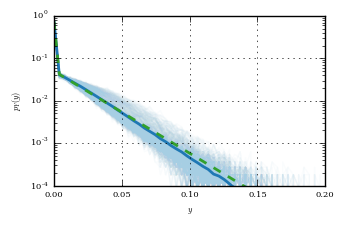

In [8]:
def bg_mixture(x, pi, s):
    # background distribution as an exponential with zero-bias
    p1 = expon.pdf(x,0,s)
    p1/=np.sum(p1)
    p1*=pi
    p = p1
    p[0] += (1-pi)
    return p

rcParams['font.size'] = 6

x = bins[:-1]
p, v = curve_fit(bg_mixture, x, h_bg, p0=[0.5, 2e-2])

print 'pi:',p[0],', s1:',p[1],' (lambda:',1.0/p[1],')'
bg_est = bg_mixture(x, p[0], p[1])
print 'kld:',kld(h_bg, bg_est)
print 'sum:',np.sum(bg_est)

plt.figure(figsize=(3.5,3.5*5/8.0))
for i in range(0,512):
    hi = np.histogram(bg_data[i,:],bins)
    plt.plot(bins[:-1],hi[0]/(np.sum(hi[0])+0.0),color='#a6cee3',alpha=0.05)

plt.plot(x, h_bg,'-',color='#1f78b4',linewidth=2.0)
# plt.plot(x, bg_est,'--',color='#b2df8a',linewidth=2.0)
plt.plot(x, bg_est,'--',color='#33a02c',linewidth=2.0)
plt.yscale('log')
plt.ylabel('$p_Y(y)$',fontsize=6)
plt.xlabel('$y$',fontsize=6)
plt.ylim([1e-4,1e0])
plt.xlim([0,.2])
plt.grid()
plt.savefig('background_mixture.pdf',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.02) # no transparency on eps!


## Object intensity distribution (aggregate)

### Load test data set

In [ ]:
test_image_list = sorted(glob('../data/test/*.png')) # window set to 2.25m to 11.25m
print len(test_image_list),'image files'
test_config_list = sorted(glob('../data/test/*.json'))
print len(test_config_list),'config files'

for i in range(0,len(test_image_list)):
    print(test_image_list[i])
    print(test_config_list[i])
    print(' ')

In [ ]:
test_data = compile(test_image_list, test_config_list, didson, True)
bins = np.linspace(0,1.0,256)
h_test = np.histogram(test_data.flatten(),bins)
h_test = h_test[0]/(np.sum(h_test[0])+0.0)     # normalize
print len(test_data.flatten())

### Fit mixture model

In [ ]:
def mixture(x, pi1, pi2, l1, l2):
    # zero bias
    p0 = np.zeros_like(x)
    p0[0]=1
    
    # background
    p1 = expon.pdf(x,0,l1)
    p1/=np.sum(p1)
    
    # object
#     p2 = expon.pdf(x,0,l2)
    p2 = rayleigh.pdf(x,0,l2)
    p2/=np.sum(p2)
    
    # mixture
    p = (1-pi1-pi2)*p0 + pi1*p1 + pi2*p2
#     print np.sum(p)
    p/=np.sum(p)
    return p

x = bins[:-1]
p, v = curve_fit(mixture, x, h_test, p0=[0.3, 0.02, 0.02, 0.15])

print('pi1=%.3f, l1= %.3f' % (p[0], p[2]))
print('pi2=%.3f, l2= %.3f' % (p[1], p[3]))
print('pi0=%.3f' % (1-p[0]-p[1]))
p_test = mixture(x,p[0],p[1],p[2],p[3])
print 'kld:', kld(h_test, p_test)

plt.figure(figsize=(3.5,3.5*5/8.0))
# for i in range(0,512):
#     hi = np.histogram(test_data[i,:],bins)
#     plt.plot(bins[:-1],hi[0]/(np.sum(hi[0])+0.0),'.',color='#a6cee3',alpha=0.05)

plt.plot(x, h_test,'-',color='#1f78b4',linewidth=2.0)
# plt.plot(x, bg_est,'--',color='#b2df8a',linewidth=2.0)
plt.plot(x, p_test,'--',color='#33a02c',linewidth=2.0)
plt.yscale('log')
plt.ylabel('$p_Y(y)$')
plt.xlabel('$y$')
plt.ylim([1e-6,1e0])
plt.xlim([0,1.0])
plt.grid()
plt.savefig('test_mixture.pdf',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.02) # no transparency on eps!


## Object intensity distribution (individual images)

In [ ]:
rcParams['font.size'] = 4

# description=('shaft','rudder','hull','fish','propeller','hull','fish','fish','hull','fish, seafloor')
description=('fish, seafloor','fish','fish','fish','hull','hull','rudder','propeller','hull','hull')


pi1 = np.zeros(10)
pi2 = np.zeros(10)
s1  = np.zeros(10) # 1/lambda 
s2  = np.zeros(10) # sigma

for idx in range(0,len(test_image_list)):
    image = (1/255.0)*imread(test_image_list[idx],as_grey = True)
    didson.loadConfig(test_config_list[idx])
    image = didson.deconvolve(image)
    image = didson.removeTaper(image)
    
#     plt.figure()
#     plt.imshow(image.transpose(),vmin=0,vmax=1)
#     plt.axis('off')
    
    bins = np.linspace(0, 1.0, 256 )
    hi = np.histogram(image[:],bins)
    
    x = hi[1][:-1].astype(np.float64)
    h_test = hi[0][:].astype(np.float64)
    h_test/=(0.0+np.sum(h_test))
    
    try:
        p, v = curve_fit(mixture, x, h_test, p0=[0.3, 0.02, 0.02, 0.15],bounds=([0,0,0.0,0],[0.5,0.5,1.0,1.0]))
        print test_image_list[idx], p
#         print 'pi1:', p[0], 'l1:',p[2]
#         print('pi1=%.3f, l1= %.3f' % (p[0], 1.0/p[2]))
#         print 'pi2:', p[1], 'l2:',p[3]
#         print('pi2=%.3f, l2= %.3f' % (p[1], 1.0/p[3]))
#         print('pi0=%.3f' % (1-p[0]-p[1]))
        p_test = mixture(x,p[0],p[1],p[2],p[3])
        kldv = kld(h_test, p_test)
#         print idx,'&',description[idx],('& %.3f & %.3f & %.3f & %.3f & %.6f \\\\ \\hline' % ( p[0], 1.0/p[2], p[1], p[3], kldv))
        pi1[idx] = p[0]
        s1[idx]  = p[2]
        pi2[idx] = p[1]
        s2[idx]  = p[3]
        print kldv
#         print 'eta:',(1-p[2])/(p[2])
    except RuntimeError:
        print 'FAILED!'
        continue

    plt.figure(figsize=(2.4,0.45))
    plt.plot(x, h_test,color='#1f78b4',alpha=0.8,linewidth=0.5)
    plt.plot(x, p_test,color='#33a02c',alpha=0.8,linewidth=0.5)
    plt.xlim([0,1])
    plt.ylim([1e-5,1e0])
#     plt.xlabel('$y$')
#     plt.ylabel('$p_Y(y)$')    
    plt.yscale('log')
    plt.grid(linewidth=.2,linestyle='-',alpha=0.5)
    ax = plt.gca()
    for side in ('top','bottom','left','right'):
        ax.spines[side].set_linewidth(0.2)
    ax.tick_params(width=0.2)    
    plt.minorticks_off()
    plt.savefig('test_mixture_'+str(idx)+'.pdf',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.02) # no transparency on eps!

# rcParams['font.size'] = 10 # default value

## Intensity distributions - full set

In [126]:
image_list = sorted(glob('../data/2016-07-19.11/raw/*.png')) # window set to 2.25m to 11.25m
config_list = sorted(glob('../data/2016-07-19.11/cfg/*.json'))
print len(image_list),'image files,',len(config_list),'config files'

N = len(image_list)
# N = 10000

41964 image files, 41964 config files


In [17]:
def mixture_pmf(x, pi1, pi2, s1, s2, L=2**8):
    """
    (1-pi1-pi2)*delta(x) + pi1*exponential(x,s1) + pi2*rayleigh(x,s2)
    """
    # background
    p1 = expon.pdf(x,loc=0,scale=s1) # background
    p1 /= np.sum(expon.pdf(np.linspace(0,1,L),loc=0,scale=s1))

    # object
    p2 = rayleigh.pdf(x,0,s2)
    p2 /= np.sum(rayleigh.pdf(np.linspace(0,1,L),0,s2))

    # print 'expon:', np.sum(p1), 'rayleigh:', np.sum(p2)

    # mixture
    p = pi1*p1 + pi2*p2
    p[x<(1.0/L)] += (1 - pi1 - pi2) # zero-bias

    return p


In [127]:
%%time
# note: running this on the full set of ~42,000 images takes a while...
# 1000  images ~ 40 s
# 10000 images ~ 400 s 
# full set     ~ 1600 s 

p = np.zeros((N,4))    # parameter array: each row is (pi1, pi2, s1, s2) 
k = np.zeros(N)
skipped=0         # skipped image counter
bins = np.linspace(0, 1.0, 257 )

# for idx in range(0,len(image_list)):
for idx in range(0,N):
    image = (1/255.0)*imread(image_list[idx],as_grey = True)
    didson.loadConfig(config_list[idx])
    
    if (didson.rx_gain!=20 or didson.min_range != 2.25 or didson.max_range!=11.25):
        skipped+=1
        continue
    didson.noise = 0.02
    image = didson.deconvolve(image)
    image = didson.removeTaper(image)
    

    hi = np.histogram(image[:],bins)
    
    x = hi[1][:-1].astype(np.float64)
    h_test = hi[0][:].astype(np.float64)
    h_test/=(0.0+np.sum(h_test))
    
    try:
#         pv, v = curve_fit(mixture_pmf, x, h_test, p0=[0.3, 0.02, 0.02, 0.15],bounds=([0,0,0.0,0],[0.5,0.5,1.0,1.0]))
        pv, v = curve_fit(mixture_pmf, x, h_test, p0=[0.3, 0.02, 0.02, 0.2])

        p[idx,:] = pv
        p_test = mixture_pmf(x,pv[0],pv[1],pv[2],pv[3])
        k[idx] = kld(h_test, p_test)
    except RuntimeError:
        print 'FAILED!'
        continue

print 'skipped',skipped,'images'        

/home/pvt/anaconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log
/home/pvt/anaconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide


skipped 0 images
CPU times: user 27min 35s, sys: 5.13 s, total: 27min 40s
Wall time: 27min 40s


pi1
	range:    0.202350148501 - 0.572153353509
	mean:     0.32147697701
	variance: 0.00060589445742
pi2
	range:    -0.202352958697 - 0.180894001173
	mean:     0.0173497958859
	variance: 0.000597327888301
s1
	range:    0.00954669861754 - 0.079022910038
	mean:     0.0191846205793
	variance: 2.38449290183e-05
s2
	range:    0.000102838252285 - 86.4781903463
	mean:     0.175532128014
	variance: 1.82943361727
k
	range:    -0.000739395237172 - 0.135630164778
	mean:     0.00607616409583
	variance: 9.61839611998e-05
1.0
1.0
1.0
1.0
CPU times: user 600 ms, sys: 16 ms, total: 616 ms
Wall time: 615 ms


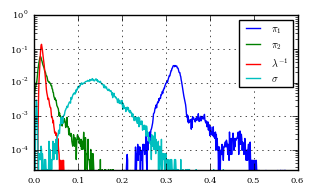

In [129]:
%%time
l = ('pi1','pi2','s1','s2')
m = -1
for i in range(0,4):
    print l[i]
    print '\trange:   ',p[:,i].min(),'-',p[:,i].max()
    print '\tmean:    ',np.mean(p[:,i])
    print '\tvariance:',np.var(p[:,i])
print 'k'
print '\trange:   ',k[~np.isnan(k)].min(),'-',k[~np.isnan(k)].max()
print '\tmean:    ',np.mean(k[~np.isnan(k)])
print '\tvariance:',np.var(k[~np.isnan(k)])
    
pi_bins = np.linspace(0,1,1001)
h_pi1 = np.histogram(p[:,0], pi_bins)
h_pi1 = h_pi1[0][:].astype(np.float64)
h_pi1 /= np.sum(h_pi1)
print np.sum(h_pi2)
h_pi2 = np.histogram(p[:,1], pi_bins)
h_pi2 = h_pi2[0][:].astype(np.float64)
h_pi2/= np.sum(h_pi2)
print np.sum(h_pi2)

plt.figure(figsize=(3.4,2))
# plt.figure(figsize=(8,8))
plt.plot(pi_bins[:-1],h_pi1,label=r'$\pi_1$')
plt.plot(pi_bins[:-1],h_pi2,label=r'$\pi_2$')
# plt.grid()
# plt.yscale('log')
# plt.legend()

s_bins = np.linspace(0,1,1001)
h_s1 = np.histogram(p[:,2], s_bins)
h_s1 = h_s1[0][:].astype(np.float64)
h_s1 /= np.sum(h_s1)
print np.sum(h_s1)
h_s2 = np.histogram(p[p[:,1]>1e-5,3], s_bins)
h_s2 = h_s2[0][:].astype(np.float64)
h_s2/= np.sum(h_s2)
print np.sum(h_s2)

# plt.figure(figsize=(3.4,2))
plt.plot(s_bins[:-1],h_s1,label=r'$\lambda^{-1}$')
plt.plot(s_bins[:-1],h_s2,label=r'$\sigma$')
plt.grid()
plt.yscale('log')
plt.xlim([0,.6])
plt.ylim([1.0/N,1])
plt.legend()

plt.savefig('par-hist.pdf',dpi=600,bbox_inches='tight',transparent=True,pad_inches=0.02) # no transparency on eps!

12867 0.135630164778
[ 0.28428562  0.01359665  0.01769294  0.00412649]


/home/pvt/anaconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less
/home/pvt/anaconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: invalid value encountered in less


<function matplotlib.pyplot.grid>

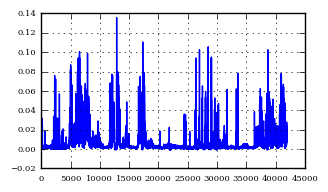

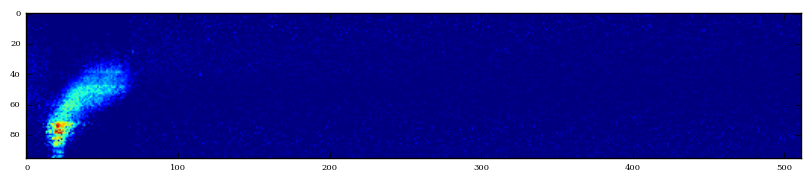

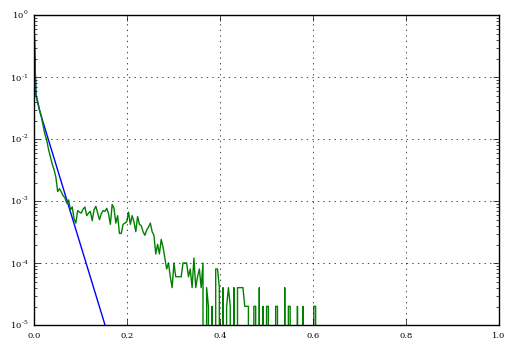

In [120]:
plt.figure(figsize=(3.4,2))
plt.plot(k)
plt.grid()
k[k<0]

print np.nanargmax(k),k[np.nanargmax(k)]
idx = np.nanargmax(k)
print p[idx,:]

image = (1/255.0)*imread(image_list[idx],as_grey = True)
didson.loadConfig(config_list[idx])

if (didson.rx_gain!=20 or didson.min_range != 2.25 or didson.max_range!=11.25):
    print 'outside spec'
didson.noise = 0.02
image = didson.deconvolve(image)
image = didson.removeTaper(image)

plt.figure(figsize=(10,2))
plt.imshow(image.transpose())
len(k[k<0.001])
plt.figure()
hi = np.histogram(image[:],bins)
h_test = hi[0][:].astype(np.float64)
h_test/=(0.0+np.sum(h_test))
p_test = mixture_pmf(x,p[idx,0],p[idx,1],p[idx,2],p[idx,3])
plt.plot(x,p_test)
plt.plot(x,h_test)
plt.yscale('log')
plt.ylim([1e-5,1])
plt.grid()

In [119]:
len(k[k<0.01])
len(k[np.isnan(k)])


/home/pvt/anaconda2/envs/multibeam/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


62